# Create your own particle size distribution for SCEPTER runs
SCEPTER simulates PSDs based on a custom input. The input can be defined with the default variables in the batch*.csv file if the PSD is a simple gaussian distribution (see `ew-workflows/tests/scepter/psd_testing.ipynb` for more info). 

We can design more complex distributions as the sum of multiple gaussians. In this case, we need to create our own psdrain.in file and save it so we can call it in the model. 

This script lets you visualize a custom distribution and save it to the appropriate directory (`SCEPTER/data`). 

In [1]:
import math 
import os
from shutil import copyfile

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np 

# Understanding the psdrain.in file 
The initial particle size distribution (PSD) is defined by the psdrain.in file. An example input for that file might be: 

`** mean radius [m], standard deviation in log10 [-], weight [-], gaussian parameters to define dust psd (e.g., 1e-5    0.2    1)`\
`5e-6    0.2 1`\
`20e-6   0.2 1`\
`50e-6   0.2 1`\
`70e-6   0.2 1`

where each line is a (gaussian) component of the total distribution. The full distribution is achieved by summing and normalizing the four gaussians (accounting for their weight).

## Create your own set of gaussian distributions
Start with the `psd_custom` dictionary, where each keyword is a column in psdrain, and each value is a row. 

In [18]:
# --- psd testing
# set up the n distributions
psd_custom = {
    "r_rain": [20/1e6, 300/1e6, 900/1e6],   # [m] mean radius of the PSD (first term in psdrain.in file)
    "sigma": [0.2, 0.2, 0.2],               # [] standard deviation in log10 (second term in psdrain.in file)
    "w": [1., 1., 1.],                      # [] weight for this component of distribution (third term in psdrain.in file)
}


## Compute the full PSD

In [19]:
# construct the PSDs
r = np.linspace(1/1e6, 2e3/1e6, 100)  # [m] range of the defined PSD 

# loop through the individual gaussians
psdlist, cdflist, p80list = [], [], []
for i in range(len(psd_custom['r_rain'])):
    r_rain_tmp = psd_custom['r_rain'][i]
    sigma_tmp = psd_custom['sigma'][i]
    w_tmp = psd_custom['w'][i]
    
    # calculate psd
    psd_tmp = w_tmp*1/sigma_tmp/np.sqrt(2*math.pi)*np.exp( -0.5*( ( np.log(r) - np.log(r_rain_tmp))/sigma_tmp )**2 )
    psdlist.append(psd_tmp)

    # get weighted psd
    if i == 0:
        psd_wtdsum = psd_tmp * w_tmp
    else:
        psd_wtdsum = psd_wtdsum + (psd_tmp * w_tmp)

# normalize psd so it sums to 1
psd_wtdsum /= np.trapezoid(psd_wtdsum, r)

# get weighted cdf 
cdf_wtdsum = np.cumsum(psd_wtdsum) * (r[1] - r[0])

# get weighted p80
p80_wtdsum = r[np.searchsorted(cdf_wtdsum, 0.8)]

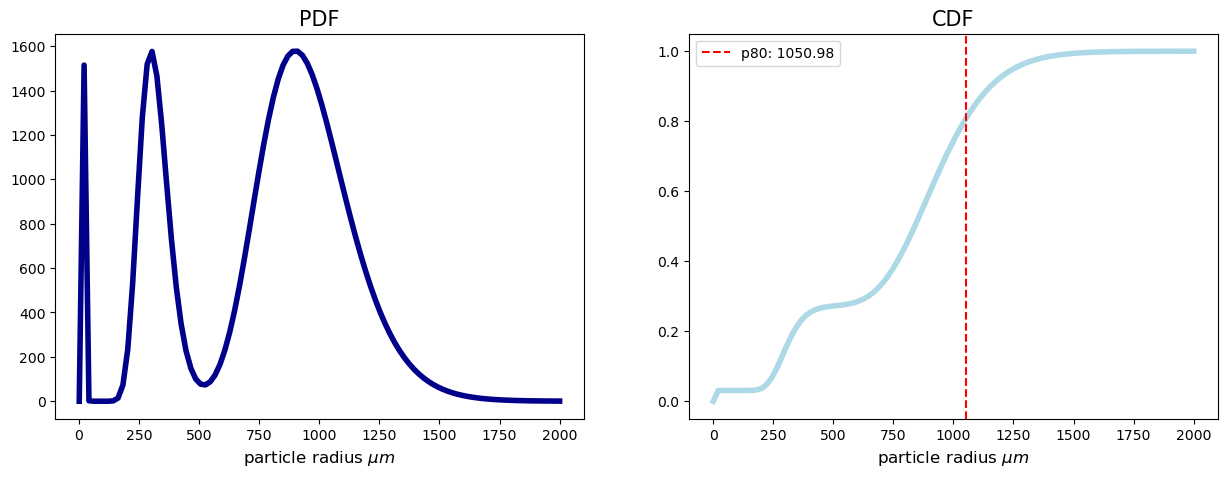

In [22]:
# --- plot the pdf and cdf 
# --- SET UP PLOT
# set up grid 
spec = GridSpec(ncols=2, nrows=1)
fig = plt.figure(figsize=(15,5))


# --- density
ax = plt.subplot(spec[0])
plt.plot(r*1e6, psd_wtdsum, c='darkblue', linewidth=4)
plt.xlabel(r'particle radius $\mu m$', fontsize=12)
plt.title("PDF", fontsize=15)

# --- cdf (for p80)
ax = plt.subplot(spec[1])
plt.plot(r*1e6, cdf_wtdsum, c='lightblue', linewidth=4)
plt.axvline(x=p80_wtdsum*1e6, color='red', linestyle = '--', label=f'p80: {np.round(p80_wtdsum*1e6, 2)}')
plt.xlabel(r'particle radius $\mu m$', fontsize=12)
plt.title("CDF", fontsize=15)
plt.legend();

# Create the custom psdrain.in file and save

In [23]:
# --- create a psdrain.in file from the psd dictionary and save it 
savehere = "/home/tykukla/SCEPTER/data"
savename = "psdrain_test0.in"

psd_header = "** mean radius [m], standard deviation in log10 [-], weight [-], gaussian parameters to define dust psd (e.g., 1e-5    0.2    1)\n"

# open a file for writing
with open(os.path.join(savehere, savename), "w") as file:
    # write the header
    file.write(psd_header)
    
    # iterate over the length of the lists (assuming all lists have the same length)
    for i in range(len(psd_custom["r_rain"])):
        # extract the ith element from each list
        if i < len(psd_custom["r_rain"]): # if it's not the last index, we add \n to make a new line
            line = f"{psd_custom['r_rain'][i]}\t{psd_custom['sigma'][i]}\t{psd_custom['w'][i]}\n"
        else: # otherwise don't add the line break \n
            line = f"{psd_custom['r_rain'][i]}\t{psd_custom['sigma'][i]}\t{psd_custom['w'][i]}"
        # Write the line to the file
        file.write(line)

In [ ]:
# -------------